In [1]:
# Install (pip install pycddlib )
#pip install pycddlib

In [2]:
import cdd
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import itertools
from dataclasses import dataclass, field
from typing import *
from abc import ABC, abstractmethod

In [3]:

def compute_dimension(vertices):
    # Convert the vertices to a numpy array
    vertices_array = np.array(vertices)
    
    # Compute the rank of the matrix of vertices
    rank = np.linalg.matrix_rank(vertices_array)

    return rank


vertices = [[0, 0, 0], [1, 1, 0], [2, 2, 0]]
print(compute_dimension(vertices)) 

vertices = [[0, 0, 0], [1, 0, 0], [0, 1, 1]]
print(compute_dimension(vertices))  

1
2


In [4]:
def verticies_to_equations(verticies):
    # first column in v_matrix is 1 to inducate verticies rather than rays
    v_matrix = np.hstack((np.ones((verticies.shape[0],1)), verticies))
    cdd_v_matrix = cdd.Matrix(np.array(v_matrix))
    vpoly = cdd.Polyhedron(cdd_v_matrix)
    equations = vpoly.get_inequalities()
    return equations

def merge_equations(equations_x, equations_y):
    return np.vstack((equations_x, equations_y))

def equations_to_verticies(equations):
    mat1 = cdd.Matrix(equations, number_type = 'float')
    mat1.rep_type = cdd.RepType.INEQUALITY
    poly1 = cdd.Polyhedron(mat1)

    gen = poly1.get_generators()

    if gen.row_size == 0:
        # empty matrix, activation pattern does not exist
        return None
    
    matrix = np.matrix([[gen[i][j] for j in range(0,gen.col_size)] for i in range(0,gen.row_size)])    

    # check that cdd lib returned verticies (not rays)
    assert np.all(matrix[:,0] == 1)

    # return just the verticies (not whether they are rays or not)
    return matrix[:,1:]

def intersection(verticies_x, verticies_y):
    equations_x = verticies_to_equations(verticies_x)
    equations_y = verticies_to_equations(verticies_y)
    equations_z = merge_equations(equations_x, equations_y)
    verticies_z = equations_to_verticies(equations_z)
    
    if verticies_z is None:
        return None

    # if edges(verticies_z) are not linearly independent, then return None (n-dimensioinal volume = 0)
    input_dims = verticies_z.shape[1] # number of coordinates in verticies is number of input dimensions
    if compute_dimension(verticies_z) < input_dims:
        # discard degenerate regions (points, lines etc. in higher dimensional space)
        return None
    
    return verticies_z

def avg_output(A_f, B_f, A_g, B_g):
    # output for region f is A_f * x + B_f
    # output for region g is A_g * x + B_g
    # return equation for region h (A_h * x + B_h) which is the average of f and g
    
    A_h = (A_f +A_g)/2
    B_h = (B_f +B_g)/2

    return A_h, B_h

def diff_output(A_f, B_f, A_g, B_g):
    # output for region f is A_f * x + B_f
    # output for region g is A_g * x + B_g
    # return equation for region h (A_h * x + B_h) which is the average of f and g
    
    A_h = (A_f - A_g)
    B_h = (B_f - B_g)

    return A_h, B_h

In [5]:
example_region = np.matrix(
    [[ 0 , 0],
     [ 0,  1],
     [ 1,  0],
     [ 1,  1]])
example_region

matrix([[0, 0],
        [0, 1],
        [1, 0],
        [1, 1]])

In [6]:
def small_neighbourhood(input_point):
    radius = 10**-6 # small value
    verticies = []
    input_dimensions = input_point.shape[0]
    for dim in range(input_dimensions):
        vertex1 = np.copy(input_point)
        vertex1[dim] -= radius
        verticies.append(vertex1)
        vertex2 = np.copy(input_point)
        vertex2[dim] += radius
        verticies.append(vertex2)
    return np.matrix(verticies)

In [7]:
example_point = np.array([0.5 , 0.5])
example_point2 = np.array([1.5 , 1.5])

In [8]:
small_neighbourhood(np.array([0.5,0.5]))

matrix([[0.499999, 0.5     ],
        [0.500001, 0.5     ],
        [0.5     , 0.499999],
        [0.5     , 0.500001]])

In [9]:
print(intersection(example_region, small_neighbourhood(example_point)))

[[0.499999 0.5     ]
 [0.5      0.499999]
 [0.500001 0.5     ]
 [0.5      0.500001]]


In [10]:
print(intersection(example_region, small_neighbourhood(example_point2)))

None


In [11]:
@dataclass
class DecisionBoundary(ABC):
    label: str
    
    @abstractmethod
    def intersection(self, Y):
        raise NotImplementedEror()
        
@dataclass
class DecisionSpace:
    boundaries: List[DecisionBoundary]

@dataclass
class DecisionBoundaryNN(DecisionBoundary):
    # y = A * x + B
    matrix_A: np.ndarray # A
    vector_B: np.ndarray # B
    vertices: np.ndarray # a numpy matrix of verticies defining the region     
    # number of items of each class in the region
    # density: List[int]
    
    def intersection(self, Y, merge_fn=avg_output):
        X = self
        vertices_x = X.vertices
        vertices_y = Y.vertices
        vertices_z = intersection(vertices_x, vertices_y)
        
        if vertices_z is None:
            return None
        
        label_z = X.label + "," + Y.label
        A_z, B_z = merge_fn(X.matrix_A, X.vector_B, Y.matrix_A, Y.vector_B)
        return DecisionBoundaryNN(label_z, A_z, B_z, vertices_z)

@dataclass
class DecisionSpaceNN(DecisionSpace):
    pass





In [12]:
def in_boundary(boundary, input_vector):
    # return true if input_vector falls in boundary
    return intersection(boundary.vertices, small_neighbourhood(input_vector)) is not None
    
def find_boundary(boundaries, input_vector):
    for boundary in boundaries:
        if in_boundary(boundary, input_vector):
            return boundary
    # no boundary found (TODO figure out what to do!)

def get_output(decision_space, input_vector):
    # find decision boundary corresponding to input
    boundaries = decision_space.boundaries
    boundary = find_boundary(boundaries, input_vector)
    
    # compute output for selected decision boundary
    A = boundary.matrix_A
    B = boundary.vector_B
    output_vector = A @ input_vector.T + B
    
    return output_vector

# 2D

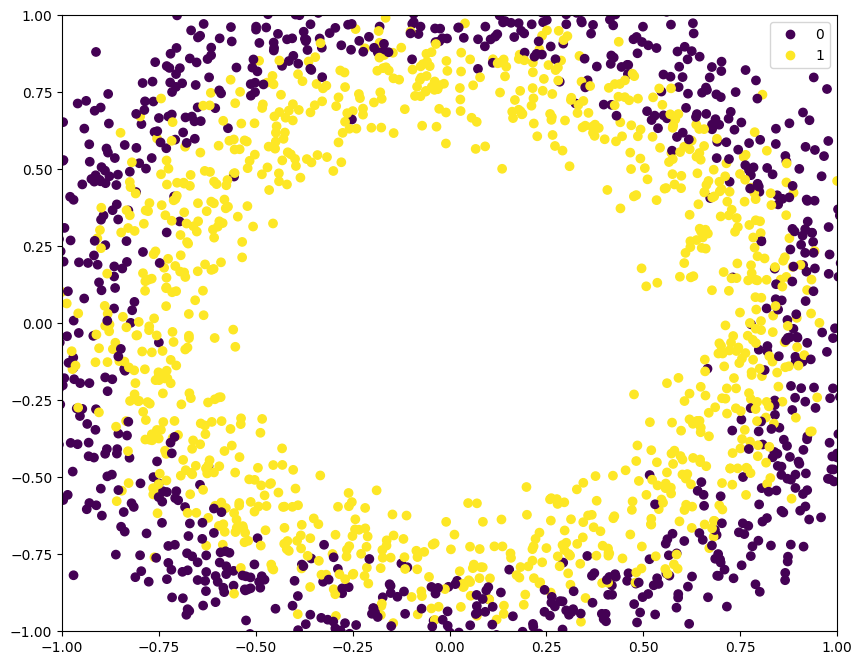

In [13]:
random_state = 0

x, y = make_circles(n_samples=2000, noise=0.1, random_state=random_state)
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=random_state)

plt.figure(figsize=(10,8))
scatter = plt.scatter(x[:, 0], x[:, 1], c=y)
plt.legend(*scatter.legend_elements(), loc="upper right")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

In [14]:
from sklearn.neural_network import MLPClassifier
mlp1 = MLPClassifier(hidden_layer_sizes=[12], max_iter=10000, early_stopping=True, 
                    n_iter_no_change=100, validation_fraction=0.2,
                    solver='adam', activation="relu", random_state=random_state, 
                    learning_rate_init=0.001)
mlp1.fit(train_x, train_y)

MLPClassifier(early_stopping=True, hidden_layer_sizes=[12], max_iter=10000,
              n_iter_no_change=100, random_state=0, validation_fraction=0.2)

In [15]:
mlp1.score(test_x, test_y)


0.8275

In [16]:
from sklearn.neural_network import MLPClassifier
mlp2 = MLPClassifier(hidden_layer_sizes=[12], max_iter=10000, early_stopping=True, 
                    n_iter_no_change=100, validation_fraction=0.2,
                    solver='adam', activation="relu", random_state=2, 
                    learning_rate_init=0.001)
mlp2.fit(train_x, train_y)

MLPClassifier(early_stopping=True, hidden_layer_sizes=[12], max_iter=10000,
              n_iter_no_change=100, random_state=2, validation_fraction=0.2)

In [17]:
mlp2.score(test_x, test_y)


0.8425

# 3D

In [18]:
# Importing necessary libraries
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import pandas as pd

# Loading the Iris dataset
iris = load_iris()
X = iris.data
Y = iris.target

# Normalizing the data
scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler.fit_transform(X)

# Creating a DataFrame
df = pd.DataFrame(X_scaled, columns=iris.feature_names)
df['species'] = Y

# Creating an interactive version of the plot using Plotly
fig = px.scatter_3d(df, x='sepal length (cm)', y='sepal width (cm)', z='petal length (cm)', color='species')
fig.show()

In [19]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [20]:
# Importing necessary libraries
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd

# Loading the Iris dataset
iris = load_iris()
X = iris.data[:, :3]  # we only take the first three features.
Y = iris.target

# Normalizing the data
scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler.fit_transform(X)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

# Creating a Multi-layer Perceptron classifier
clf = MLPClassifier(hidden_layer_sizes=(4,), max_iter=1000, random_state=42)

# Training the MLP classifier
clf.fit(X_train, y_train)

# Predicting the test set results
y_pred = clf.predict(X_test)

# Showing the classification report
print(classification_report(y_test, y_pred, target_names=iris.target_names))


              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.89      0.94         9
   virginica       0.92      1.00      0.96        11

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.97        30
weighted avg       0.97      0.97      0.97        30



/Users/anupamchaudhauri/Library/Caches/pypoetry/virtualenvs/tree-diff-vPVmu6Ox-py3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.



In [21]:
clf.coefs_

[array([[ 0.45799416,  0.60666886, -0.3837783 ,  0.20343058],
        [-1.40892887, -0.29871337,  0.15346897, -0.46660415],
        [ 0.85541443,  0.1695168 , -1.81304229,  2.11935373]]),
 array([[-1.15158292,  0.77567292,  0.01904687],
        [-0.54227863,  0.01965567, -0.49861632],
        [ 0.83888307, -1.44124621, -1.27713659],
        [-0.45331296, -1.96662119,  1.21208481]])]

In [22]:
clf.intercepts_

[array([ 1.56682064, -0.75000781,  0.12972501, -0.19187742]),
 array([ 0.09619564, -0.22260902, -0.41782931])]

In [23]:
def get_coefs_and_intercepts(eg="3D"):
    if eg == "aletheia":
        #Aletheia weights
        coefs = [np.array([[ 1.26330575,  0.81106997,  2.28835997,  0.66100558],
                [ 0.37596265,  0.36973942, -0.85882211,  2.02183899]]),
         np.array([[ 0.87355974],
                [ 1.89058246],
                [-1.89513973],
                [-2.56049663]])]
        intercepts = [np.array([ 1.47921924,  0.93827836, -0.02134388, -0.4247285 ]),
         np.array([-0.66509044])]
    elif eg == "2D_1":
        # 2D weights (concentric circles)
        coefs = mlp1.coefs_
        intercepts = mlp1.intercepts_
    elif eg == "2D_2":
        # 2D weights (concentric circles)
        coefs = mlp2.coefs_
        intercepts = mlp2.intercepts_
    elif eg == "3D":
        # 3D weights
        coefs = clf.coefs_
        intercepts = clf.intercepts_
    else:
        raise Exception()
    
    return coefs, intercepts

coefs1, intercepts1 = get_coefs_and_intercepts("2D_1")
coefs2, intercepts2 = get_coefs_and_intercepts("2D_2")

In [24]:
coefs1, intercepts1

([array([[ 2.97177439e-78,  2.49486396e-01,  5.43809498e-02,
           2.08641839e-01, -1.20820792e+00,  2.52878980e-01,
          -4.43672084e-02,  2.57100926e+00,  1.97963771e+00,
           3.90996486e-02,  1.60329210e-21, -2.00341683e+00],
         [ 1.46048019e-73,  8.86432085e-01, -4.43395272e-01,
           7.92738277e-02, -2.34038432e+00,  2.33348246e+00,
           2.98668468e-01,  5.62774226e-02,  1.12818479e+00,
           7.89353116e-01, -4.53606407e-81,  1.78551409e+00]]),
  array([[ 5.97350493e-60],
         [ 1.28320393e+00],
         [ 5.26340157e-01],
         [ 1.14811234e+00],
         [-2.00510442e+00],
         [-2.83942845e+00],
         [ 2.20937941e-01],
         [-2.22355614e+00],
         [-1.34514645e+00],
         [ 1.40055008e+00],
         [-1.14065587e-20],
         [-2.88757955e+00]])],
 [array([-0.4997961 ,  1.43298714, -0.57332733,  1.62675938, -0.22862614,
         -0.83553247, -0.36823687, -0.05593793, -0.28316436,  1.27874136,
         -0.63005205,

In [25]:
coefs2, intercepts2

([array([[-5.63276908e-02, -2.00726023e+00,  6.86701563e-01,
           1.45574131e-61, -4.36025354e-02, -1.88461098e+00,
          -1.14096346e-01,  3.77340725e-01, -5.41273693e-01,
          -1.83701553e+00,  1.72355330e+00,  8.03284491e-01],
         [-4.14461000e-01,  1.13990909e-01, -1.53612625e+00,
           8.77707625e-16,  3.70030144e-01,  8.34763433e-01,
           1.38205593e-01, -1.81915161e+00, -9.96868547e-01,
          -1.72734896e+00,  1.54082751e+00, -9.46396986e-01]]),
  array([[ 3.26171190e-01],
         [-1.44417380e+00],
         [-2.37678028e+00],
         [ 8.16107262e-24],
         [ 5.74990830e-01],
         [-2.06683918e+00],
         [ 2.62687478e-01],
         [-2.01974251e+00],
         [ 1.96107416e+00],
         [-2.13833581e+00],
         [-2.11505333e+00],
         [-8.30709735e-01]])],
 [array([-0.54505779, -0.43699187, -0.21152776, -0.5146289 , -0.45333475,
         -0.18669428, -0.22627655, -0.37914741,  2.11753456, -0.82943292,
         -0.21433746,

In [26]:
def vector_mask_to_matrix(v):
    return np.eye(v.shape[0]) * v

In [27]:
def find_activation_region_layer_l(coefs, intercepts, pattern_l, pattern_previous,
                                   A_previous, B_previous, layer,
                                   constraints_A, constraints_B):
    # pattern is a column vector, 1 => active, 0 => inactive
    # convert to                  1 => active, -1 => inactive (to make it easier to flip equations)
    inequality_dir = pattern_l * 2 - 1 # 1 -> 1, 0 -> -1
    #print("inequality_dir", inequality_dir)
    
    #constraints_A, constraints_b = get_constraints_layer1(pattern_layer1, coefs, intercepts)
    
    W_l = coefs[layer].transpose()
    
    # Convert pattern previous to matrix
    pattern_previous_matrix = vector_mask_to_matrix(pattern_previous)
    
    A_l = (W_l @ pattern_previous_matrix @ A_previous) * inequality_dir
    
    # need to negate A_l as solves -Ax + b > 0
    A = np.vstack((-A_l, constraints_A))
    
    b_l = intercepts[layer][:,np.newaxis]
    B_l = (W_l @ pattern_previous_matrix @ B_previous + b_l) * inequality_dir

    b = np.vstack((B_l, constraints_B))
    
    #import pdb; pdb.set_trace()
    
    # compute H = [b - A] to represent system of inequalities,
    # and use pycddlib to solve and find verticies of resultant polytope that satisfies inequalities
        
    H = np.hstack((b,-A))
    

    mat1 = cdd.Matrix(H, number_type = 'float')
    mat1.rep_type = cdd.RepType.INEQUALITY
    poly1 = cdd.Polyhedron(mat1)
    #print("H matrix", poly1)
    
    gen = poly1.get_generators()
    #print(gen)
    #print("V matrix", gen)

    if gen.row_size == 0:
        # empty matrix, activation pattern does not exist
        return None
    
    matrix = np.matrix([[gen[i][j] for j in range(0,gen.col_size)] for i in range(0,gen.row_size)])    

    # check that cdd lib returned verticies (not rays)
    assert np.all(matrix[:,0] == 1)

    # return just the verticies (not whether they are rays or not)
    # also returns linear equation for region (A_l * x + B_l) and full set of constraints (A, b)
    return matrix[:,1:], A_l, B_l, A, b, pattern_l

In [28]:
def generate_regions(coefs, intercepts, layer):
    """
    Generates regions for the given layer
    coefs - weight coefs for NN generated by scikit-learn
    intercepts - biases for NN generated by scikit-learn
    layer - number of layers
    """

    def get_num_inputs():
        return coefs[0].shape[0]
        
    def get_neurons(l):
        return intercepts[l].shape[0]
    
    matricies = []

    # todo filter to just the activation patterns that have non-zero area
    perms_layers = []
    for l in range(layer):
        neurons_l = get_neurons(l)
        perms_l = list(itertools.product([0,1], repeat=neurons_l))
        perms_layers.append(perms_l)

    
    prev_results = []
    
    # 1st layer is special
    # assuming n layers
    for perm1 in perms_layers[0]:
        pattern_layer1 = np.array(perm1)[:,np.newaxis]

        # additional terms in A for constraints on x1, x2, ...:
        #x1 + 1 > 0
        #x2 + 1 > 0
        #x3 + 1 > 0
        # and also:
        #x1 - 1 < 0
        #x2 - 1 < 0
        #x3 - 1 < 0
        #..
        num_inputs = get_num_inputs()
        constraints_A_layer1 = np.vstack(
            (np.eye(num_inputs),
             -np.eye(num_inputs))
        )
        
        # additional terms in b for constraints on x1 and x2
        #x1 + 1 > 0
        #x2 + 1 > 0
        #x3 + 1 > 0
        #x1 - 1 < 0
        #x2 - 1 < 0
        #x3 - 1 < 0
        constraints_b_layer1 = np.ones((2 * num_inputs,1))
        
        neurons_layer1 = get_num_inputs()

        # layer 1 is index 0 in coefs
        # treat (non-existant) previous layer as all active neurons with identity
        result_1 = find_activation_region_layer_l(
                                    coefs, intercepts, pattern_layer1, np.ones(num_inputs),
                                    np.eye(num_inputs), np.zeros(num_inputs)[:,np.newaxis], 0,
                                    constraints_A_layer1, constraints_b_layer1)

        if result_1 is None:
            #print(f"could not find region for {perm1}")
            continue

        prev_results.append((result_1, [perm1]))
    
    # breadth-first iteration over all pattern results in each layer
    for l in range(1, layer):
        results = []
        
        for prev_result, prev_perms in prev_results:
            matrix_prev, A_lprev, B_lprev, A_prev, b_prev, pattern_layer_prev = prev_result
            
            for perm in perms_layers[l]:
                pattern_layer = np.array(perm)[:,np.newaxis]

                # layer 2 is index 1 in coefs
                result_l = find_activation_region_layer_l(
                                            coefs, intercepts, pattern_layer, pattern_layer_prev,
                                            A_lprev, B_lprev, l,
                                            A_prev, b_prev)

                if result_l is None:
                    #print(f"could not find region for {perm}")
                    continue
                
                results.append((result_l, prev_perms + [perm]))
        
        prev_results = results
    
    #matricies = []
    decision_boundaries = []
    
    for prev_result, prev_perms in prev_results:
        matrix, A_l, B_l, A_2, b_2, pattern = prev_result
        #matricies.append((matrix, str(prev_perms)))
        boundary = DecisionBoundaryNN(str(prev_perms), A_l, B_l, matrix)
        decision_boundaries.append(boundary)
    
    #return matricies
    return DecisionSpaceNN(decision_boundaries)


In [29]:
from scipy.spatial import ConvexHull
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.tri as tri
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap

def plot_decision_space_nn(decision_space : DecisionSpaceNN, output_dim=0, vis_out=True, shading='gouraud',
                          vmin=0, vmax=7):
    norm = colors.Normalize(vmin=vmin, vmax=vmax)

    # Define a color map that linearly transitions from black to white
    cmap = LinearSegmentedColormap.from_list('black_to_white', ['black', 'white'], N=256)


    for boundary in decision_space.boundaries: # plot just first boundary
        vertices = np.array(boundary.vertices) # use np.array not np.matrix
        label =  boundary.label
        
        # compute the convex hull of the points
        hull = ConvexHull(vertices)

        # extract the x and y coordinates of the convex hull
        x = vertices[hull.vertices, 0]
        y = vertices[hull.vertices, 1]
        
        # output = A * input + B
        A = boundary.matrix_A
        B = boundary.vector_B
        input_vect = np.vstack((x.T, y.T))
        #import pdb; pdb.set_trace()
        output = A @ input_vect + B
        
        # Allow to select dimension (for now plot output dimension 0)
        output = output[output_dim]
        #print(max(output), min(output))

        # create a triangulation
        #import pdb; pdb.set_trace()
        #triang = tri.Triangulation(x.flatten(), y.flatten())

        # plot the triangles with colors
        #plt.tripcolor(triang, output, cmap=cm.viridis, alpha=0.3, edgecolors='k')
        #import pdb; pdb.set_trace()
        if vis_out:
            # shade triangle proportional to output
            plt.tripcolor(x.flatten(), y.flatten(), output, norm=norm, cmap=cmap, shading=shading)
        else:
            plt.fill(x, y, alpha=0.3, label=label, edgecolor='k')
            #plt.plot(x, y, 'ko')
            plt.scatter(x, y, c=output, norm=norm, cmap=cmap)
                
        # If working, should always be 2 (same as input)
        # print(compute_dimension(vertices))

        #plt.plot(x, y, 'ko')

        # plot and fill the polygon
        #plt.fill(x, y, color=cm.viridis(output), alpha=0.3, label=label)

    # set the axis labels and title
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.xlabel('X axis')
    plt.ylabel('Y axis')
    plt.title('Polygon Plot')

    # show the plot with a colorbar
    if vis_out:
        plt.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()


/var/folders/wh/_6hqbxsx5_z_8z9zp8cf2k900000gp/T/ipykernel_50342/2413157146.py:71: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


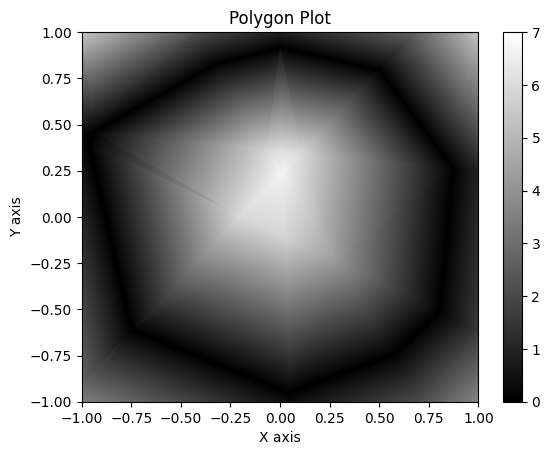

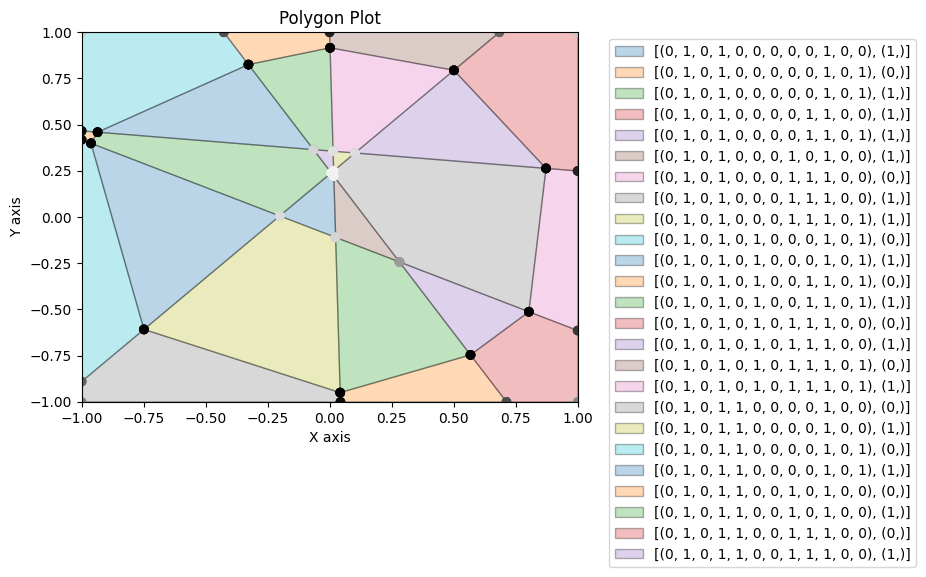

In [30]:
decision_space_1 = generate_regions(coefs1, intercepts1, 2)
plot_decision_space_nn(decision_space_1,0)
plot_decision_space_nn(decision_space_1,0,False)

/var/folders/wh/_6hqbxsx5_z_8z9zp8cf2k900000gp/T/ipykernel_50342/2413157146.py:71: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


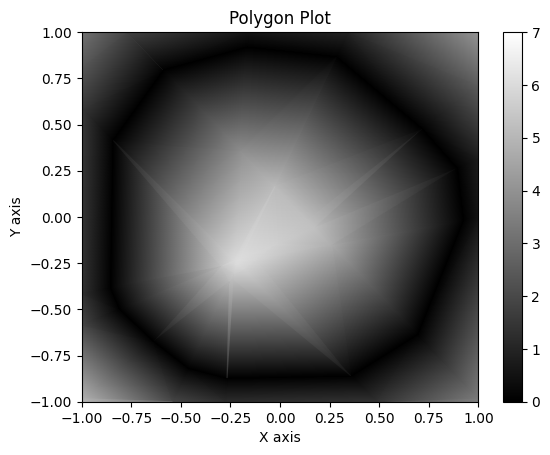

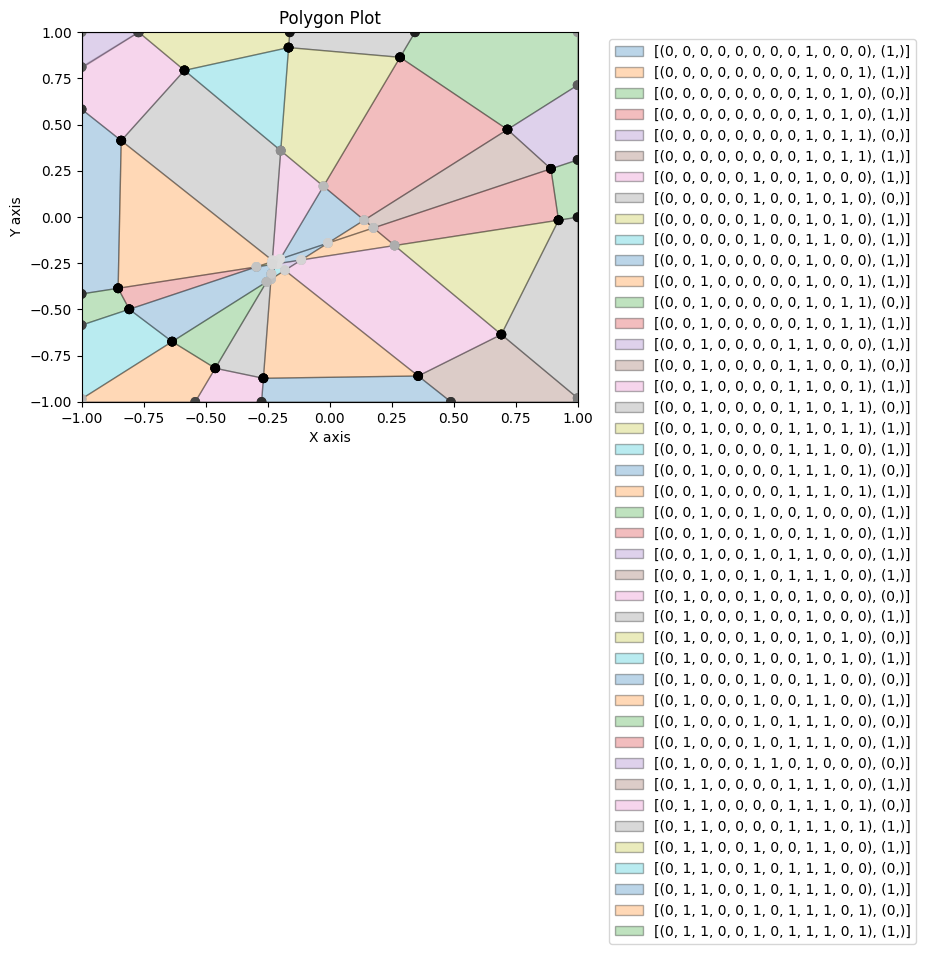

In [31]:
decision_space_2 = generate_regions(coefs2, intercepts2, 2)
plot_decision_space_nn(decision_space_2,0)
plot_decision_space_nn(decision_space_2,0,False)

In [32]:
##Intersection 

In [33]:
# sanity test: intersection with self should give same result (but may list points in a different order)
intersection(decision_space_1.boundaries[0].vertices, decision_space_1.boundaries[0].vertices)

matrix([[ 0.00652255,  0.23954593],
        [ 0.01691279,  0.22131407],
        [ 0.0241686 , -0.11016431],
        [-0.20137845,  0.00627286]])

In [34]:
decision_space_1.boundaries[0].vertices

matrix([[ 0.01691279,  0.22131407],
        [ 0.0241686 , -0.11016431],
        [-0.20137845,  0.00627286],
        [ 0.00652255,  0.23954593]])

In [35]:
def merge_decision_space(X, Y, merge_fn=avg_output):
    Z = []
    for boundary_x in X.boundaries:
        for boundary_y in Y.boundaries:
            intersection = boundary_x.intersection(boundary_y, merge_fn)
            if intersection is not None:
                Z.append(intersection)
    return DecisionSpace(Z)


/var/folders/wh/_6hqbxsx5_z_8z9zp8cf2k900000gp/T/ipykernel_50342/2413157146.py:71: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


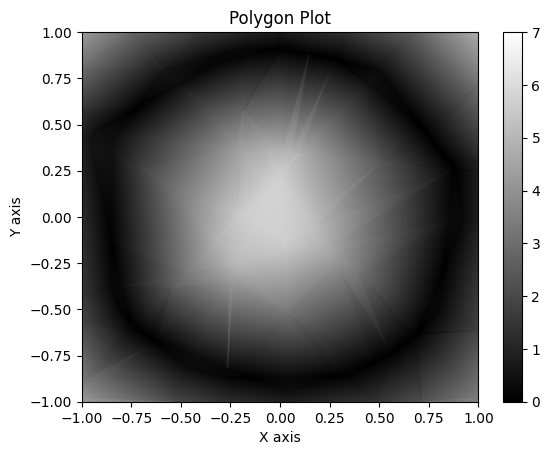

In [36]:
decision_space_3 = merge_decision_space(decision_space_1, decision_space_2)
plot_decision_space_nn(decision_space_3,0)

/var/folders/wh/_6hqbxsx5_z_8z9zp8cf2k900000gp/T/ipykernel_50342/2413157146.py:71: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


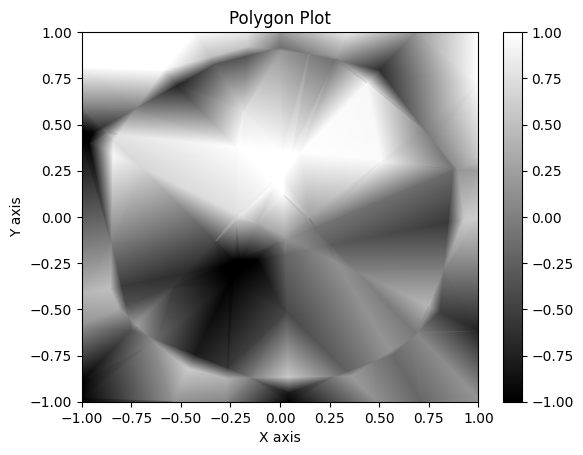

In [37]:
decision_space_4 = merge_decision_space(decision_space_1, decision_space_2, merge_fn=diff_output)
plot_decision_space_nn(decision_space_4,0,vmin=-1, vmax=1)

In [38]:
len(decision_space_1.boundaries)

25

In [39]:
len(decision_space_2.boundaries)

43

In [40]:
len(decision_space_3.boundaries)

136

In [41]:
print(get_output(decision_space_1, np.array([0,0])))
print(get_output(decision_space_2, np.array([0,0])))
print(get_output(decision_space_3, np.array([0,0])))

[[6.08650511]]
[[5.39080778]]
[[5.73865645]]


In [45]:
print(get_output(decision_space_1, np.array([0.6,0.8])))
print(get_output(decision_space_2, np.array([0.6,0.8])))
print(get_output(decision_space_4, np.array([0.6,0.8])))

[[0.87330339]]
[[1.15108049]]
[[-0.2777771]]
